# Infection régionale française avec le nouveau coronavirus (SARS-CoV-2), COVID-19

## Introduction

*English:*

Data science should offer accessible insight. Charts are powerful tools for revealing analysis, but require careful thought. During this period of incredible uncertainty around COVID-19 distribution and impact, the following 
charts are designed to present:

- Country-level: current rates of hospitalisation, intensive care, death, and patient cure, including how close intensive care numbers are to the available number of beds;
- Regional: 
  - Daily-case counts of hospitalisation, intensive care, death, and patient cure;
  - Changes in doubling times for hospitalisation, intensive care, death, and patient cure;
  - Daily to cumulative hospitalisation rates for all regions;

I will try to keep these charts up to date during the pandemic. Feel free to use them as you wish. Code released under BSD-3 license and everything else as CC-By.

**NOTE:** Only regional charts presented, since there are so many national charts around, but the code for other aggregations and experiments is included.

*Francais:*

La science des données doit offrir un aperçu accessible. Les graphiques sont des outils puissants pour révéler l'analyse, mais ils nécessitent une réflexion approfondie. Pendant cette période d'incertitude incroyable autour de la distribution et de l'impact de COVID-19, les éléments suivants 
Les graphiques sont conçus pour présenter :

- Au niveau du pays: les taux actuels d'hospitalisation, de soins intensifs, de décès et de guérison des patients, y compris l'écart entre le nombre de soins intensifs et le nombre de lits disponibles;
- au niveau régional: 
  - Nombre de cas quotidiens d'hospitalisation, de soins intensifs, de décès et de guérison de patients;
  - Évolution du doublement des durées d'hospitalisation, de soins intensifs, de décès et de guérison des patients;
  - Taux d'hospitalisation journaliers à cumulés pour toutes les régions;

Je vais essayer de tenir ces tableaux à jour pendant la pandémie. N'hésitez pas à les utiliser comme vous le souhaitez. Code publié sous licence BSD-3 et tout le reste en tant que CC-By.

**NOTEZ:** Seules les cartes régionales sont présentées, car il y a beaucoup de cartes nationales, mais le code pour les autres agrégations et expériences est inclus.

---
## Hypothèses

*English:*

The data used in these charts has come from an evolving and rapidly-moving set of sources. All are derived from Santé publique France, but the way in which they are presented keeps changing. At present, data starts 2020-03-18, and includes the following:

- Number of people currently hospitalized
- Number of people currently in resuscitation or critical care
- Total amount of patient that returned home
- Total amout of deaths at the hospital

These are not compatible numbers. It isn't clear whether hospitalisation includes those in critical care. My current approach is that a total number of people who received critical care isn't possible from these data, but that a total number of people receiving care for each day can be derived from:

    current_hospitalised + total_cured + total_deaths
    
*Francais:*

Les données utilisées dans ces graphiques proviennent d'un ensemble de sources en évolution rapide. Elles sont toutes issues de Santé publique France, mais la manière dont elles sont présentées ne cesse d'évoluer. À l'heure actuelle, les données commencent le 2020-03-18, et comprennent les éléments suivants

- Nombre de personnes actuellement hospitalisées	
- Nombre de personnes actuellement en réanimation ou soins intensifs
- Nombre cumulé de personnes retournées à domicile
- Nombre cumulé de personnes décédées

Ces numéros ne sont pas compatibles. Il n'est pas clair si l'hospitalisation inclut les personnes en soins intensifs. Mon approche actuelle est que le nombre total de personnes ayant reçu des soins intensifs n'est pas possible à partir de ces données, mais qu'un nombre total de personnes recevant des soins pour chaque jour peut être déduit :

    current_hospitalised + total_cured + total_deaths

---
## *Data*

- [Données hospitalières relatives à l'épidémie de COVID-19](https://www.data.gouv.fr/fr/datasets/donnees-hospitalieres-relatives-a-lepidemie-de-covid-19/)
- [Chiffres-clés concernant l'épidémie de COVID19 en France](https://www.data.gouv.fr/en/datasets/chiffres-cles-concernant-lepidemie-de-covid19-en-france/)
- [Données des urgences hospitalières et de SOS médecins relatives à l'épidémie de COVID-19](https://www.data.gouv.fr/en/datasets/donnees-des-urgences-hospitalieres-et-de-sos-medecins-relatives-a-lepidemie-de-covid-19/#_)
- [Code Officiel Géographique (COG)](https://www.data.gouv.fr/fr/datasets/code-officiel-geographique-cog/)

*Dependences || Exigences*: Pandas, Matplotlib, GeoPandas, GeoPlot, Tabulate, Seaborn

In [42]:
%matplotlib inline

import pandas as pd
import numpy as np
import geopandas as gpd
import geoplot as gplt
import geoplot.crs as gcrs
from datetime import datetime
from matplotlib import pyplot as plt, rc
import matplotlib.gridspec as gridspec
from matplotlib import cm
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import math
from datetime import datetime, timedelta
import matplotlib.dates as mdates
import matplotlib.units as munits
converter = mdates.ConciseDateConverter()
munits.registry[np.datetime64] = converter
munits.registry[datetime.date] = converter
munits.registry[datetime] = converter
from tabulate import tabulate
import seaborn as sns
import urllib.request

In [43]:
## Constants

current_source = "https://www.data.gouv.fr/fr/datasets/donnees-hospitalieres-relatives-a-lepidemie-de-covid-19/"
ICU_beds = 14000
start_date = "2020-03-18"
start_date = datetime.strptime(start_date, "%Y-%m-%d")

url = "https://www.data.gouv.fr/fr/datasets/r/63352e38-d353-4b54-bfd1-f1b3ee1cabd7"
data_file = "data/hospital-data-covid19.csv"

rename_columns = {
    "dep": "Région", 
    "jour": "Date",
    "hosp": "Actuellement-hospitalisées",
    "rea": "Actuellement-réanimation",
    "dc": "Cumulatif-décédées",
    "rad": "Cumulatif-guéries", 
}

In [44]:
## Functions

def doubling_time(x, y, z):
    """
    x est le temps qui s'est écoulé depuis que vous avez commencé à mesurer. 
        Par exemple, si le nombre de cas est passé de 500 le jour 0 à 1000 le jour 2, x est égal à 2.
    y est le nombre de cas au jour x, par exemple 1000 au jour 2.
    z est le nombre de cas au jour 0, par exemple 500.
    """
    if y > 0 and z > 0 and math.log(y/z):
        return (x*math.log(2))/(math.log(y/z))
    return np.nan

def parse_num(x):
    x = str(x)
    if len(x) < 2:
        # Making sure it is of form "01" and not "1"
        x = ("0" * (2 - len(x))) + x
    return x

def get_regions():
    departements = "data/france-departements.csv"
    pf = pd.read_csv(departements)
    return dict(zip([parse_num(x) for x in pf["code"].unique()], pf["region"]))

def get_latest_data(data_file):
    df = pd.read_csv(data_file, sep=";")
    df = df[df["sexe"]==0]
    df["dep"] = df["dep"].replace(get_regions())
    del df["sexe"]
    df = df.groupby(['dep','jour']).sum().reset_index()
    df = df.rename(columns=rename_columns)
    df["Cumulatif-hospitalisées"] = df["Actuellement-hospitalisées"] + \
                                    df["Cumulatif-décédées"] + \
                                    df["Cumulatif-guéries"]
    df["Date"] = pd.to_datetime(df.Date)
    new_columns = {
        "Cumulatif-hospitalisées": "Hospitalisées",
        "Actuellement-réanimation": "Réanimation",
        "Cumulatif-décédées": "Décédées",
        "Cumulatif-guéries": "Guéries",
    }
    for c, nc in new_columns.items():
        # https://stackoverflow.com/a/48348006
        df[nc] = df.groupby(["Région"])[c].diff().fillna(df[c])
    indicator_columns = [
         "Hospitalisées", "Actuellement-hospitalisées", "Cumulatif-hospitalisées",
         "Réanimation", "Actuellement-réanimation",
         "Décédées", "Cumulatif-décédées",
         "Guéries", "Cumulatif-guéries"
    ]
    new_types = {c: "int32" for c in indicator_columns}
    df = df.astype(new_types)
    df[indicator_columns] = np.where(df[indicator_columns]<0, 0, df[indicator_columns])
    return df

In [45]:
## Setup

urllib.request.urlretrieve(url, data_file)
df = get_latest_data(data_file)
latest_date = df["Date"].max()
color_sequence = sns.color_palette("colorblind", df["Région"].unique().size)
df[df["Date"] == latest_date]

,Région,Date,Actuellement-hospitalisées,Actuellement-réanimation,Cumulatif-guéries,Cumulatif-décédées,Cumulatif-hospitalisées,Hospitalisées,Réanimation,Décédées,Guéries
26,Auvergne-Rhône-Alpes,2020-04-13,3055,671,2970,794,6819,85,0,21,34
53,Bourgogne-Franche-Comté,2020-04-13,1309,284,1463,512,3284,49,6,12,22
80,Bretagne,2020-04-13,510,118,490,136,1136,13,0,4,9
107,Centre-Val de Loire,2020-04-13,983,196,595,214,1792,67,3,13,14
134,Corsica,2020-04-13,75,15,126,38,239,3,1,2,0
161,French Guiana,2020-04-13,15,1,13,0,28,0,0,0,0
188,Grand Est,2020-04-13,4928,880,4788,2105,11821,145,2,41,63
215,Guadeloupe,2020-04-13,41,18,51,10,102,3,0,0,0
242,Hauts-de-France,2020-04-13,2525,543,2102,873,5500,101,0,33,27
269,Martinique,2020-04-13,39,16,52,6,97,1,1,0,0


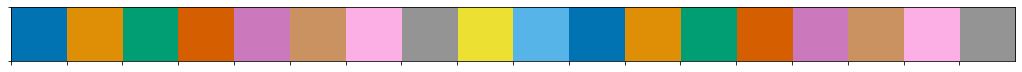

In [6]:
sns.palplot(sns.color_palette("colorblind", df["Région"].unique().size))

# Régional France COVID-19 : mise à jour cumulative

In [54]:
def set_plot(ax):
    # set theme
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax

def line_shadow_plot(ax, df_plot, region, column, plot_log=False):
    for r, data in df_plot.groupby(["Région"]):
        x = [pd.to_datetime(dt).date() for dt in data["Date"].values]
        # https://matplotlib.org/3.1.0/gallery/ticks_and_spines/date_concise_formatter.html
        locator = mdates.AutoDateLocator(minticks=3, maxticks=7)
        formatter = mdates.ConciseDateFormatter(locator)
        ax.xaxis.set_major_locator(locator)
        ax.xaxis.set_major_formatter(formatter)
        y = data[column].values
        if r == region:
            xr = x
            yr = y
            continue        
        line_plot = ax.plot(x, y, lw=2.5, color="gainsboro")
    line_plot = ax.plot(xr, yr, lw=2.5, color=clr_bl)
    if plot_log: ax.set_yscale("log")
    return ax

def add_doubling(ax, data, column, strt_dt, end_dt):
    ax.annotate("doublé en", (0.04, 0.88), xycoords='axes fraction',
                fontsize=11, fontweight="light", color="grey")
    bbox_props = dict(boxstyle="Round4,pad=0.5", fc=clr_bl, ec=clr_bl, lw=2)
    yN = data[data["Date"] == strt_dt].iloc[0][column]
    zN = data[data["Date"] == end_dt].iloc[0][column]
    dN = doubling_time(x=N, y=yN, z=zN)
    if dN >= 0: doubling = F"{dN:.1f} jours"
    else: doubling = "∞ jours"
    ax.annotate(doubling, (0.06, 0.78), xycoords='axes fraction', va='center', 
                fontsize=12, fontweight="bold", color="white",
                bbox=bbox_props)
    return ax

def line_matrix_multiples(dfl, column, plot_log=False):
    fig = plt.figure(figsize=(20, 10))
    plt.style.use('seaborn-darkgrid')
    sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})
    fig.patch.set_facecolor('white')
    clr_bl = "#2267BD"
    # Columns, rows, and regions
    columns = 6
    region_count = len(dfl["Région"].unique())
    rows = int(round(region_count/columns)) + (region_count/columns - int(round(region_count/columns)) > 0)
    region_order = dfl[dfl["Date"] == latest_date].sort_values(by=column, 
                                                               ascending=False)["Région"].unique()
    # Dates
    N = 5
    date_N = latest_date - timedelta(days=N)
    row = -1
    index = -1
    for count, region in enumerate(region_order):
        if not(count%columns): row+=1
        if not(count%columns): index=-1
        index+=1
        ax = plt.subplot2grid((rows, columns), (row, index))
        ax = line_shadow_plot(set_plot(ax), dfl, region, column, plot_log=plot_log)
        ax.set_title(F"{region}", loc='left', fontsize=14, fontweight=2, color=clr_bl)
        ax = add_doubling(ax, dfl[dfl["Région"]==region], column, latest_date, date_N)
        if index == 0 or index == columns-1:
            ax.get_yaxis().set_visible(True)
            if index == columns-1:
                ax.yaxis.tick_right()
                ax.yaxis.set_label_position("right")
        if row == rows-1:
            ax.get_xaxis().set_visible(True)
    title = F"France régions COVID-19 : {' '.join(column.split('-'))} depuis {latest_date.date().isoformat()}"
    fig.suptitle(title, fontsize=20, ha='center')
    text = F"""
    CC-By @GavinChait https://gavinchait.com
    Code: https://github.com/turukawa/coding-notes/
    Data: {current_source}"""
    plt.gcf().text(0.02, 0.02, text, fontsize=10)
    fig.tight_layout(rect=(0,0.08,1,0.94))
    plt.subplots_adjust(wspace=0.01)

In [48]:
text = F"""
Regional France COVID-19 : Cumulative deaths and doubling-times since {latest_date.date().isoformat()}.
Régional France COVID-19 : Nombre cumulé de décès et temps de doublement depuis {latest_date.date().isoformat()}
#opendata
"""
print(text)


Regional France COVID-19 : Cumulative deaths and doubling-times since 2020-04-13.
Régional France COVID-19 : Nombre cumulé de décès et temps de doublement depuis 2020-04-13
#opendata



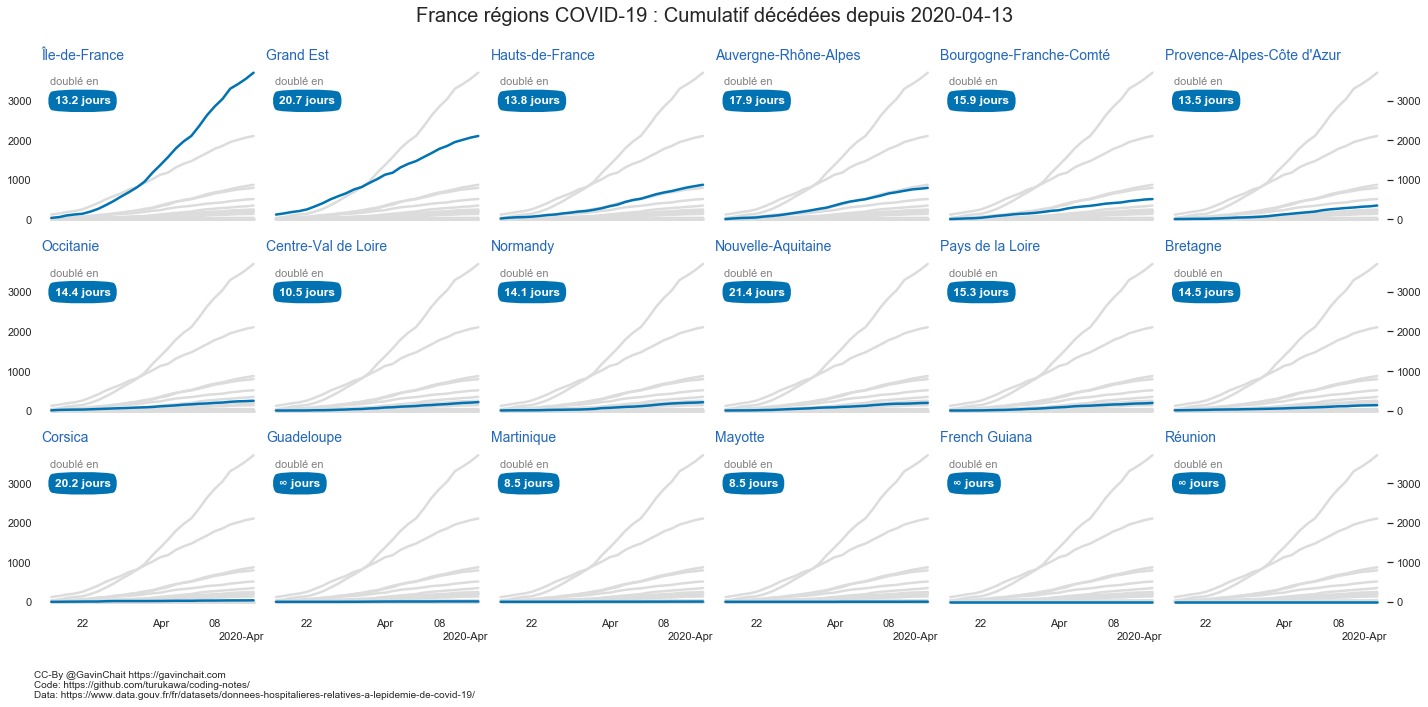

In [55]:
dfl = df.copy()
column = "Cumulatif-décédées"
line_matrix_multiples(dfl, column, plot_log=False)

In [52]:
text = F"""
Regional France COVID-19 : Cumulative hospitalisation and doubling-times since {latest_date.date().isoformat()}.
Régional France COVID-19 : Cumul des hospitalisations et doublement des durées depuis {latest_date.date().isoformat()}
#opendata
"""
print(text)


Regional France COVID-19 : Cumulative hospitalisation and doubling-times since 2020-04-13.
Régional France COVID-19 : Cumul des hospitalisations et doublement des durées depuis 2020-04-13
#opendata



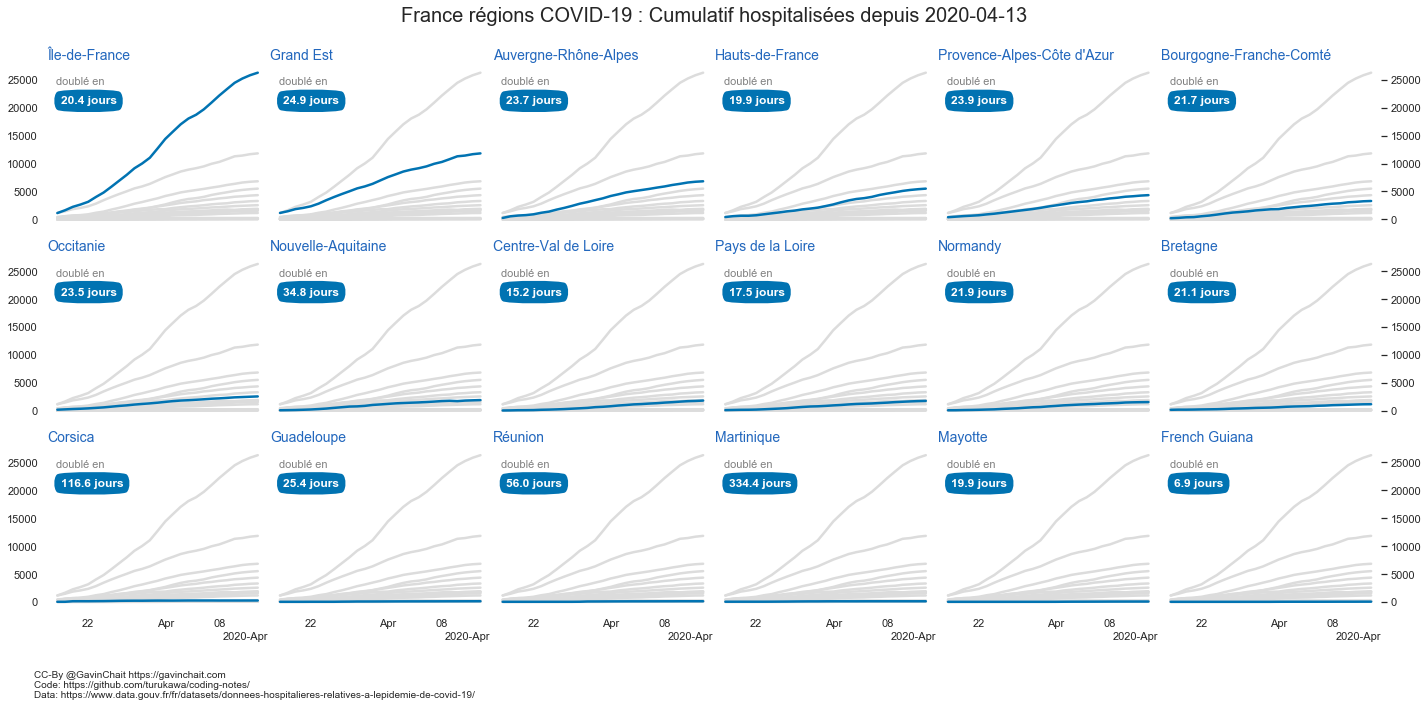

In [61]:
dfl = df.copy()
column = "Cumulatif-hospitalisées"
line_matrix_multiples(dfl, column, plot_log=False)

In [62]:
text = F"""
Regional France COVID-19 : Actual critical care patients and doubling-times since {latest_date.date().isoformat()}.
Régional France COVID-19 : Nombre réel de patients en soins intensifs et doublement des durées depuis {latest_date.date().isoformat()}
#opendata
"""
print(text)


Regional France COVID-19 : Actual critical care patients and doubling-times since 2020-04-13.
Régional France COVID-19 : Nombre réel de patients en soins intensifs et doublement des durées depuis 2020-04-13
#opendata



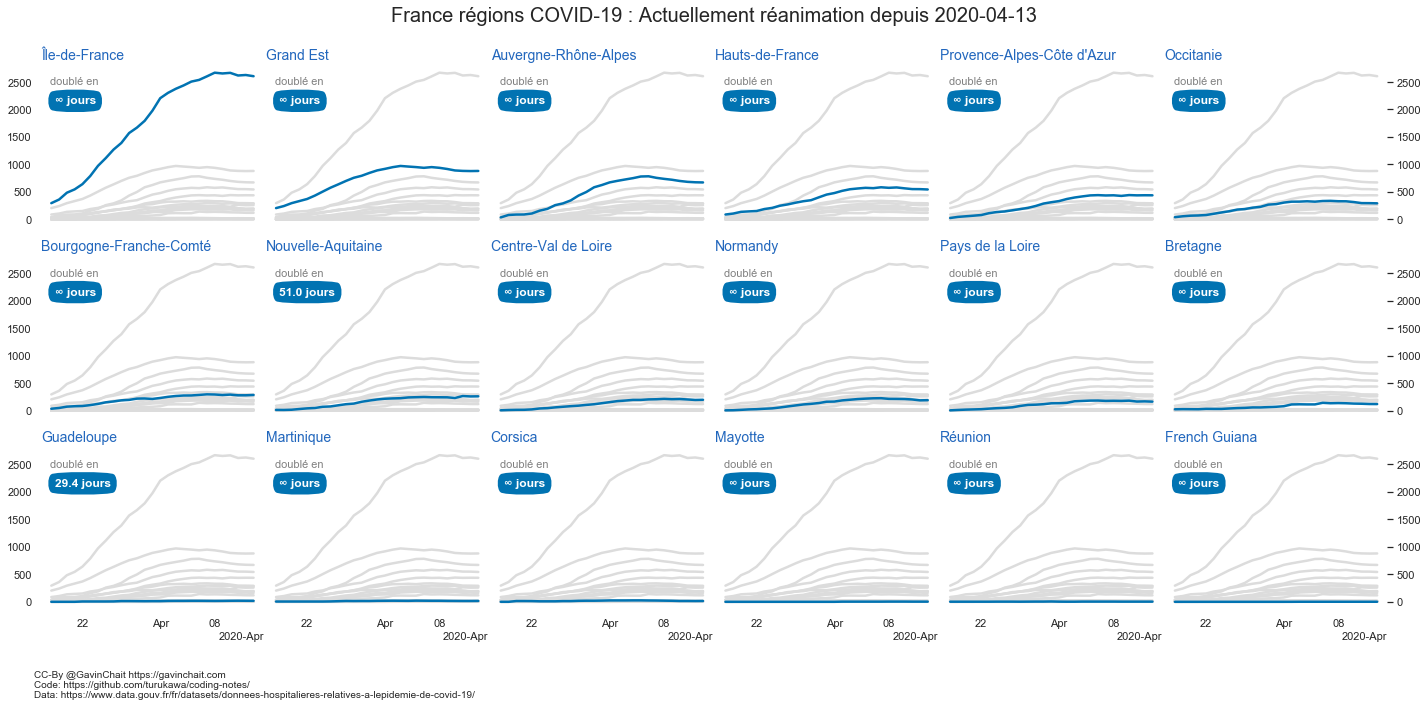

In [56]:
dfl = df.copy()
column = "Actuellement-réanimation"
line_matrix_multiples(dfl, column, plot_log=False)

In [57]:
text = F"""
Regional France COVID-19 : cumulative update of infection status since {latest_date.date().isoformat()}.
Régional France COVID-19 : mise à jour cumulative du statut de l'infection depuis {latest_date.date().isoformat()}. 
#opendata
"""
print(text)


Regional France COVID-19 : cumulative update of infection status since 2020-04-13.
Régional France COVID-19 : mise à jour cumulative du statut de l'infection depuis 2020-04-13. 
#opendata



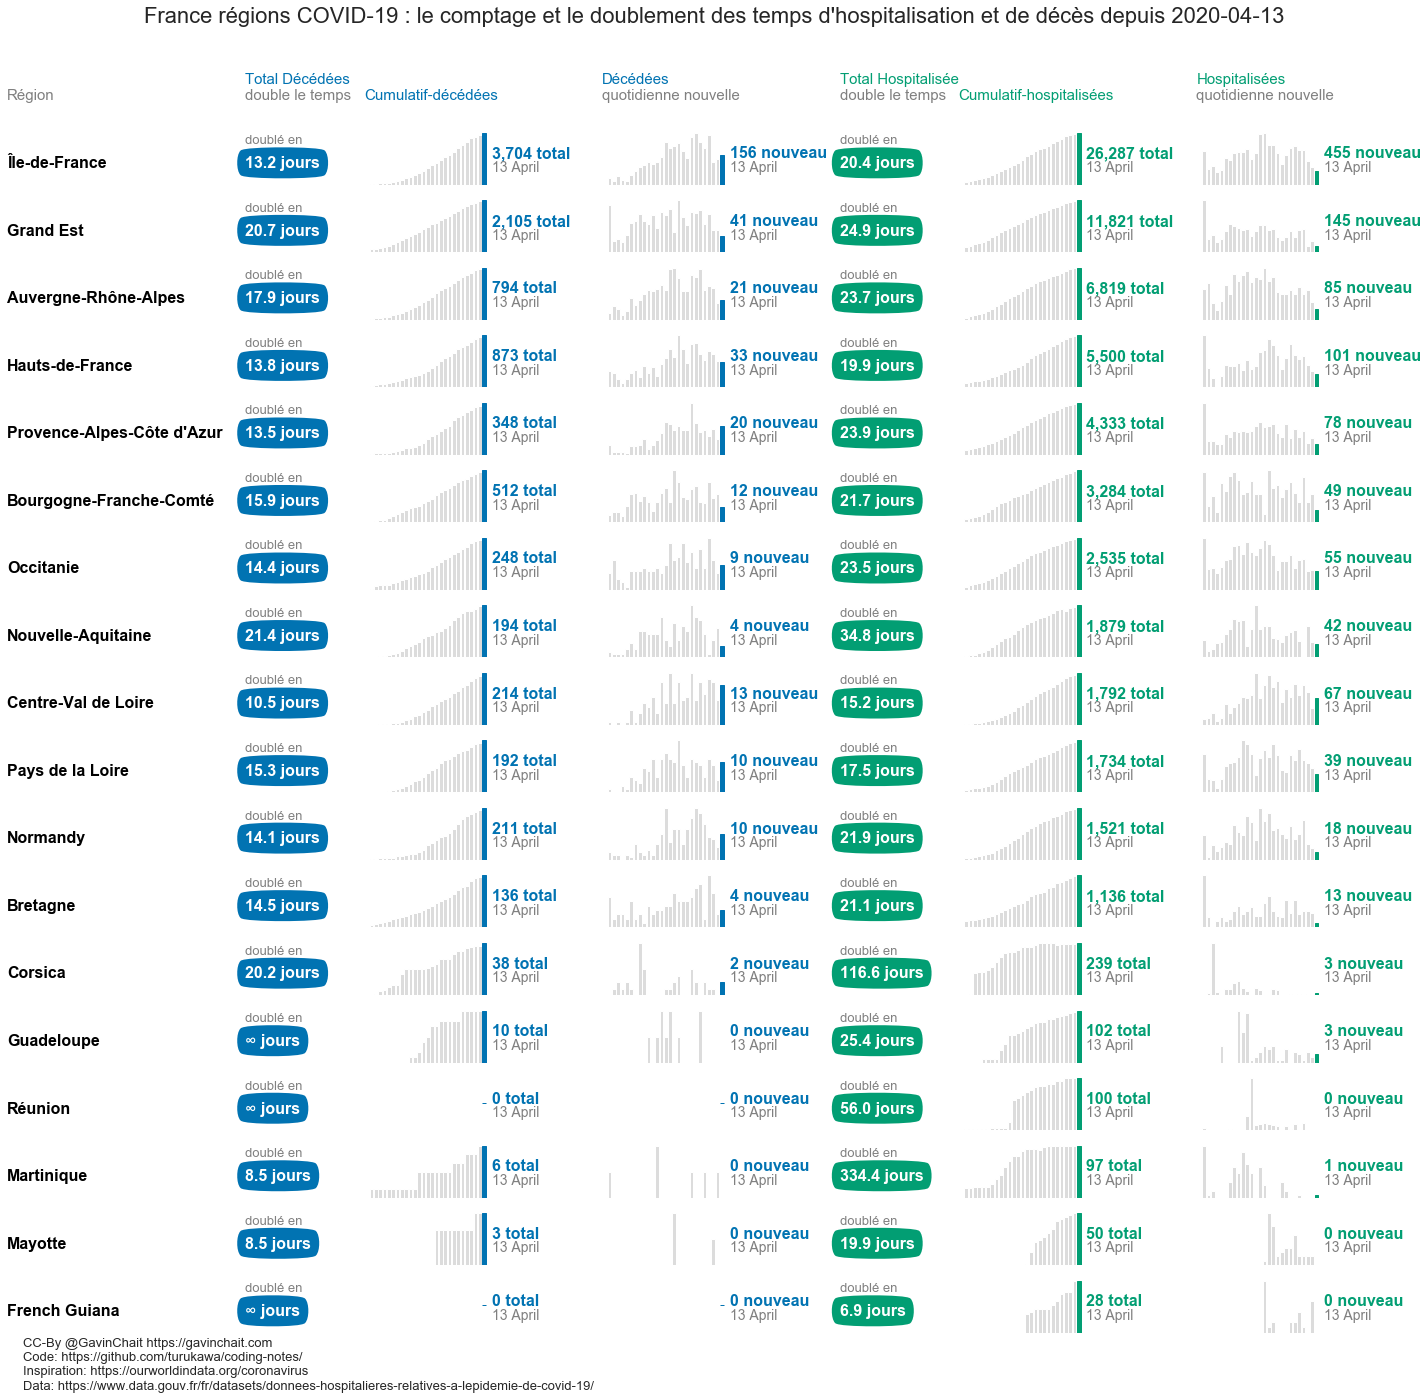

In [58]:
# Inspired by https://ourworldindata.org/coronavirus
def get_sub_axes(rows, columns, row, index, column_span=2):
    ax = plt.subplot2grid((rows, columns), (row, index), colspan=column_span)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax

def spark_bar(rows, columns, row, index, x, y, text_val, text_date, clr):
    # set theme
    ax = plt.subplot2grid((rows, columns), (row, index), colspan=2)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    barWidth = 0.85
    bar_plot = ax.bar(x, y, color="gainsboro", width=barWidth)
    bar_plot[-1].set_color(clr)
    ax.annotate(text_val, (1, 0.58), xycoords='axes fraction', va='center', 
                fontsize=16, fontweight="bold", color=clr)
    ax.annotate(text_date, (1, 0.32), xycoords='axes fraction', va='center', 
                fontsize=14, fontweight="ultralight", color="grey")
    return ax

## Create chart

dfl = df.copy()
plot_rows = ["Décédées", "Guéries", 
                "Hospitalisées", "Réanimation"]
plot_columns = ["Cumulatif-décédées", "Cumulatif-guéries", 
                "Cumulatif-hospitalisées", "Cumulatif-réanimation"] + plot_rows

plot_rows = ["Décédées", "Hospitalisées"]
plot_columns = ["Cumulatif-décédées", "Cumulatif-hospitalisées"] + plot_rows

fig = plt.figure(figsize=(20, 20))
plt.style.use('seaborn-darkgrid')
sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})
fig.patch.set_facecolor('white')

N = 5
date_N = latest_date - timedelta(days=N)
rows = 1 + dfl["Région"].unique().size
columns = int(2 + len(plot_rows) * 5)
clr_bl = color_sequence[0]
clr_gr = color_sequence[2]

## Set up column headings
# Region
ax = get_sub_axes(rows, columns, 0, 0)
ax.annotate("Région", (0, 0.4), xycoords='axes fraction', va='center', 
            fontsize=15, fontweight="normal", color="grey")
# Temps de doublement
ax = get_sub_axes(rows, columns, 0, 2, column_span=1)
ax.annotate(F"Total {plot_rows[0]}", (0, 0.7), xycoords='axes fraction', va='center', 
            fontsize=15, fontweight="normal", color=clr_bl)
ax.annotate("double le temps", (0, 0.4), xycoords='axes fraction', va='center', 
            fontsize=15, fontweight="normal", color="grey")
# Cumulatifs
ax = get_sub_axes(rows, columns, 0, 3)
ax.annotate(F"{plot_columns[0]}", (0, 0.4), xycoords='axes fraction', va='center', 
            fontsize=15, fontweight="normal", color=clr_bl)
# Quotidienne nouvelle
ax = get_sub_axes(rows, columns, 0, 5)
ax.annotate(F"{plot_rows[0]}", (0, 0.7), xycoords='axes fraction', va='center', 
            fontsize=15, fontweight="normal", color=clr_bl)
ax.annotate("quotidienne nouvelle", (0, 0.4), xycoords='axes fraction', va='center', 
            fontsize=15, fontweight="normal", color="grey")
# Temps de doublement
ax = get_sub_axes(rows, columns, 0, 7, column_span=1)
ax.annotate(F"Total {plot_rows[1]}", (0, 0.7), xycoords='axes fraction', va='center', 
            fontsize=15, fontweight="normal", color=clr_gr)
ax.annotate("double le temps", (0, 0.4), xycoords='axes fraction', va='center', 
            fontsize=15, fontweight="normal", color="grey")
# Cumulatifs
ax = get_sub_axes(rows, columns, 0, 8)
ax.annotate(F"{plot_columns[1]}", (0, 0.4), xycoords='axes fraction', va='center', 
            fontsize=15, fontweight="normal", color=clr_gr)
# Quotidienne nouvelle
ax = get_sub_axes(rows, columns, 0, 10)
ax.annotate(F"{plot_rows[1]}", (0, 0.7), xycoords='axes fraction', va='center', 
            fontsize=15, fontweight="normal", color=clr_gr)
ax.annotate("quotidienne nouvelle", (0, 0.4), xycoords='axes fraction', va='center', 
            fontsize=15, fontweight="normal", color="grey")

## Create data
# Sort regions into order by number hospitalised
region_order = dfl[dfl["Date"] == latest_date].sort_values(by="Cumulatif-hospitalisées", 
                                                           ascending=False)["Région"].unique()
for row, region in enumerate(region_order):
    data = dfl[dfl["Région"] == region].copy()
    data.sort_values(by="Date", ascending=True, inplace=True)
    row+=1
    drawing = pd.pivot_table(data[["Région", "Date"] + plot_columns], 
                         values=plot_columns,
                         index=["Région"],
                         columns=["Date"])
    # Region
    index = 0
    ax = plt.subplot2grid((rows, columns), (row, index), colspan=2)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    region = F"{drawing.index[0]}"
    ax.annotate(region, (0, 0.4), xycoords='axes fraction', va='center', 
                fontsize=16, fontweight="bold", color="black")
    clrs = [clr_bl, clr_gr]
    for indicator in range(len(plot_rows)):
        count = plot_rows[indicator]
        cumulative = F"Cumulatif-{count.lower()}"
        clr = clrs[indicator]
        # Doubling time
        index+=2
        ax = plt.subplot2grid((rows, columns), (row, index))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax.annotate("doublé en", (0, 0.81), xycoords='axes fraction', va='center', 
                    fontsize=13, fontweight="light", color="grey")
        bbox_props = dict(boxstyle="Round4,pad=0.5", fc=clr, ec=clr, lw=2)
        yN = data[data["Date"] == latest_date].iloc[0][cumulative]
        zN = data[data["Date"] == date_N].iloc[0][cumulative]
        dN = doubling_time(x=N, y=yN, z=zN)
        #ltst = drawing[cumulative].values[0][-1]
        #indx = np.argmax(drawing[cumulative].values[0]>ltst/2)
        if dN >= 0: doubling = F"{dN:.1f} jours"
        else: doubling = "∞ jours"
        ax.annotate(doubling, (0.02, 0.4), xycoords='axes fraction', va='center', 
                    fontsize=16, fontweight="bold", color="white",
                    bbox=bbox_props)
        # Cumulatif
        index+=1
        ax = spark_bar(
            rows, columns, row, index,
            [dt.date() for dt in drawing[cumulative].columns],
            drawing[cumulative].values[0],
            F"{drawing[cumulative].values[0][-1]:,} total",
            F"{latest_date.day} {latest_date.strftime('%B')}",
            clr
        )
        # Daily
        index+=2
        ax = spark_bar(
            rows, columns, row, index,
            [dt.date() for dt in drawing[count].columns],
            drawing[count].values[0],
            F"{drawing[count].values[0][-1]:,} nouveau",
            F"{latest_date.day} {latest_date.strftime('%B')}",
            clr
        )
title = F"France régions COVID-19 : le comptage et le doublement des temps d'hospitalisation et de décès depuis {latest_date.date().isoformat()}"
fig.suptitle(title, fontsize=22, ha='center')
text = F"""
CC-By @GavinChait https://gavinchait.com
Code: https://github.com/turukawa/coding-notes/
Inspiration: https://ourworldindata.org/coronavirus
Data: {current_source}"""
plt.gcf().text(0.02, 0.02, text, fontsize=13)
fig.tight_layout(rect=(0,0.05,1,0.95))

In [59]:
text = F"""
Regional France COVID-19 : counts and doubling in the last 5 days and the previous 5 days since {latest_date.date().isoformat()}.
Régional France COVID-19 : comptages et doublements dans les 5 derniers jours et les 5 jours précédents depuis {latest_date.date().isoformat()}
#opendata
"""
print(text)


Regional France COVID-19 : counts and doubling in the last 5 days and the previous 5 days since 2020-04-13.
Régional France COVID-19 : comptages et doublements dans les 5 derniers jours et les 5 jours précédents depuis 2020-04-13
#opendata



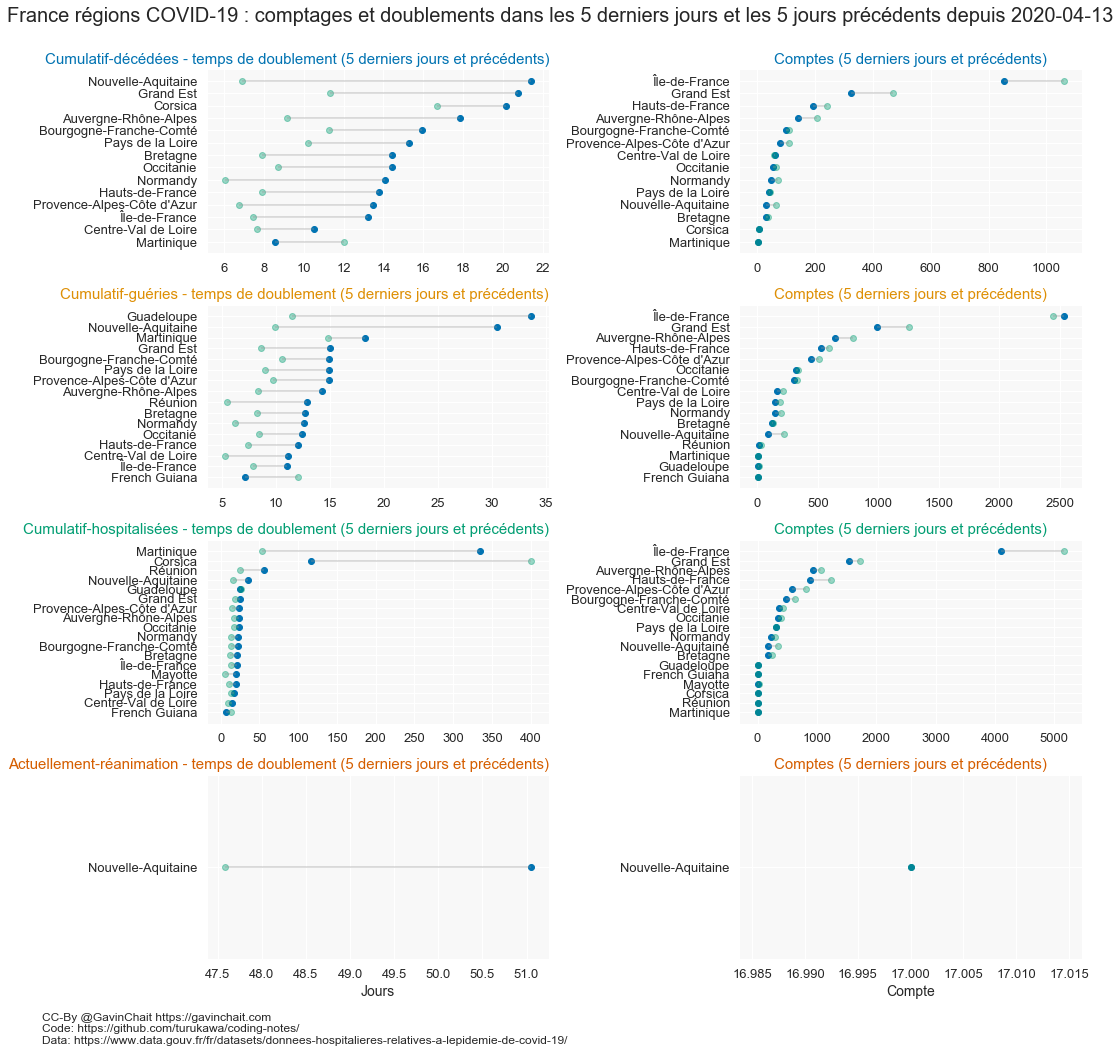

In [60]:
# https://python-graph-gallery.com/184-lollipop-plot-with-2-groups/
# https://seaborn.pydata.org/examples/distplot_options.html
dfl = df.copy()
plot_columns = ["Cumulatif-décédées", "Cumulatif-guéries", 
                "Cumulatif-hospitalisées", "Actuellement-réanimation"]

fig, axes = plt.subplots(len(plot_columns), 2, figsize=(15, 15), sharex=True, sharey=True)

plt.style.use('seaborn-darkgrid')
sns.set(rc={'axes.facecolor':'#F8F8F8', 'figure.facecolor':'white'})
fig.patch.set_facecolor('white')

N = 5
date_N = latest_date - timedelta(days=N)
date_2N = date_N - timedelta(days=N)
pN = 0
for clr, column in enumerate(plot_columns):
    pN+=1
    double_N = []
    double_2N = []
    count_N = []
    count_2N = []
    region = []
    #le doublement du temps au cours des cinq derniers jours
    #dans les cinq jours précédents
    for r, data in dfl.groupby("Région"):
        # Lates
        yN = data[data["Date"] == latest_date].iloc[0][column]
        zN = data[data["Date"] == date_N].iloc[0][column]
        # le doublement du temps au cours des cinq derniers jours
        dN = doubling_time(x=N, y=yN, z=zN)
        if np.isnan(dN): continue  
        # les nouveaux cas confirmés au cours des cinq derniers jours
        cN = yN - zN
        if cN < 0: continue
        # Précédent
        y2N = data[data["Date"] == date_N].iloc[0][column]
        z2N = data[data["Date"] == date_2N].iloc[0][column]
        # le doublement du temps au cours des cinq derniers jours
        d2N = doubling_time(x=N, y=y2N, z=z2N)
        if np.isnan(d2N): continue
        # les cas confirmés dans les cinq jours précédents
        c2N = y2N - z2N
        if c2N < 0: continue
        region.append(r)
        double_N.append(dN)
        double_2N.append(d2N)
        count_N.append(cN)
        count_2N.append(c2N)
    # Prepare plot
    df_plot = pd.DataFrame({"Région": region, 
                            "double_N": double_N , "double_2N": double_2N,
                            "count_N": count_N , "count_2N": count_2N
                           })
    # Plot doubling
    plt.subplot(len(plot_columns), 2, pN)
    df_plot.sort_values(by="double_N", inplace=True)
    plt.hlines(y=df_plot["Région"], xmin=df_plot["double_N"], xmax=df_plot["double_2N"], 
               color=color_sequence[7], alpha=0.4)
    plt.scatter(df_plot["double_N"], df_plot["Région"], 
                color=color_sequence[0], alpha=1, label='value1')
    plt.scatter(df_plot["double_2N"], df_plot["Région"], 
                color=color_sequence[2], alpha=0.4 , label='value2')
    plt.yticks(fontsize=13, fontweight=0)
    plt.xticks(fontsize=13, fontweight=0)
    plt.title(F"{column} - temps de doublement (5 derniers jours et précédents)", 
              loc='right', fontsize=15, fontweight=2, color=color_sequence[clr])
    if clr+1 == len(plot_columns):
        plt.xlabel("Jours", fontsize=14, fontweight=0)
    # Plot counts
    pN+=1
    plt.subplot(len(plot_columns), 2, pN)
    df_plot.sort_values(by="count_N", inplace=True)
    plt.hlines(y=df_plot["Région"], xmin=df_plot["count_N"], xmax=df_plot["count_2N"], 
               color=color_sequence[7], alpha=0.4)
    plt.scatter(df_plot["count_N"], df_plot["Région"], 
                color=color_sequence[0], alpha=1)
    plt.scatter(df_plot["count_2N"], df_plot["Région"], 
                color=color_sequence[2], alpha=0.4)
    plt.yticks(fontsize=13, fontweight=0)
    plt.xticks(fontsize=13, fontweight=0)
    plt.title(F"Comptes (5 derniers jours et précédents)", 
              loc='center', fontsize=15, fontweight=2, color=color_sequence[clr])
    if clr+1 == len(plot_columns):
        plt.xlabel("Compte", fontsize=14, fontweight=0)
title = F"France régions COVID-19 : comptages et doublements dans les 5 derniers jours et les 5 jours précédents depuis {latest_date.date().isoformat()}"
fig.suptitle(title, fontsize=20, ha='center')
text = F"""
CC-By @GavinChait https://gavinchait.com
Code: https://github.com/turukawa/coding-notes/
Data: {current_source}"""
plt.gcf().text(0.02, 0.02, text, fontsize=12)
fig.tight_layout(rect=(0,0.05,1,0.95))

# France COVID-19 : mise à jour cumulative

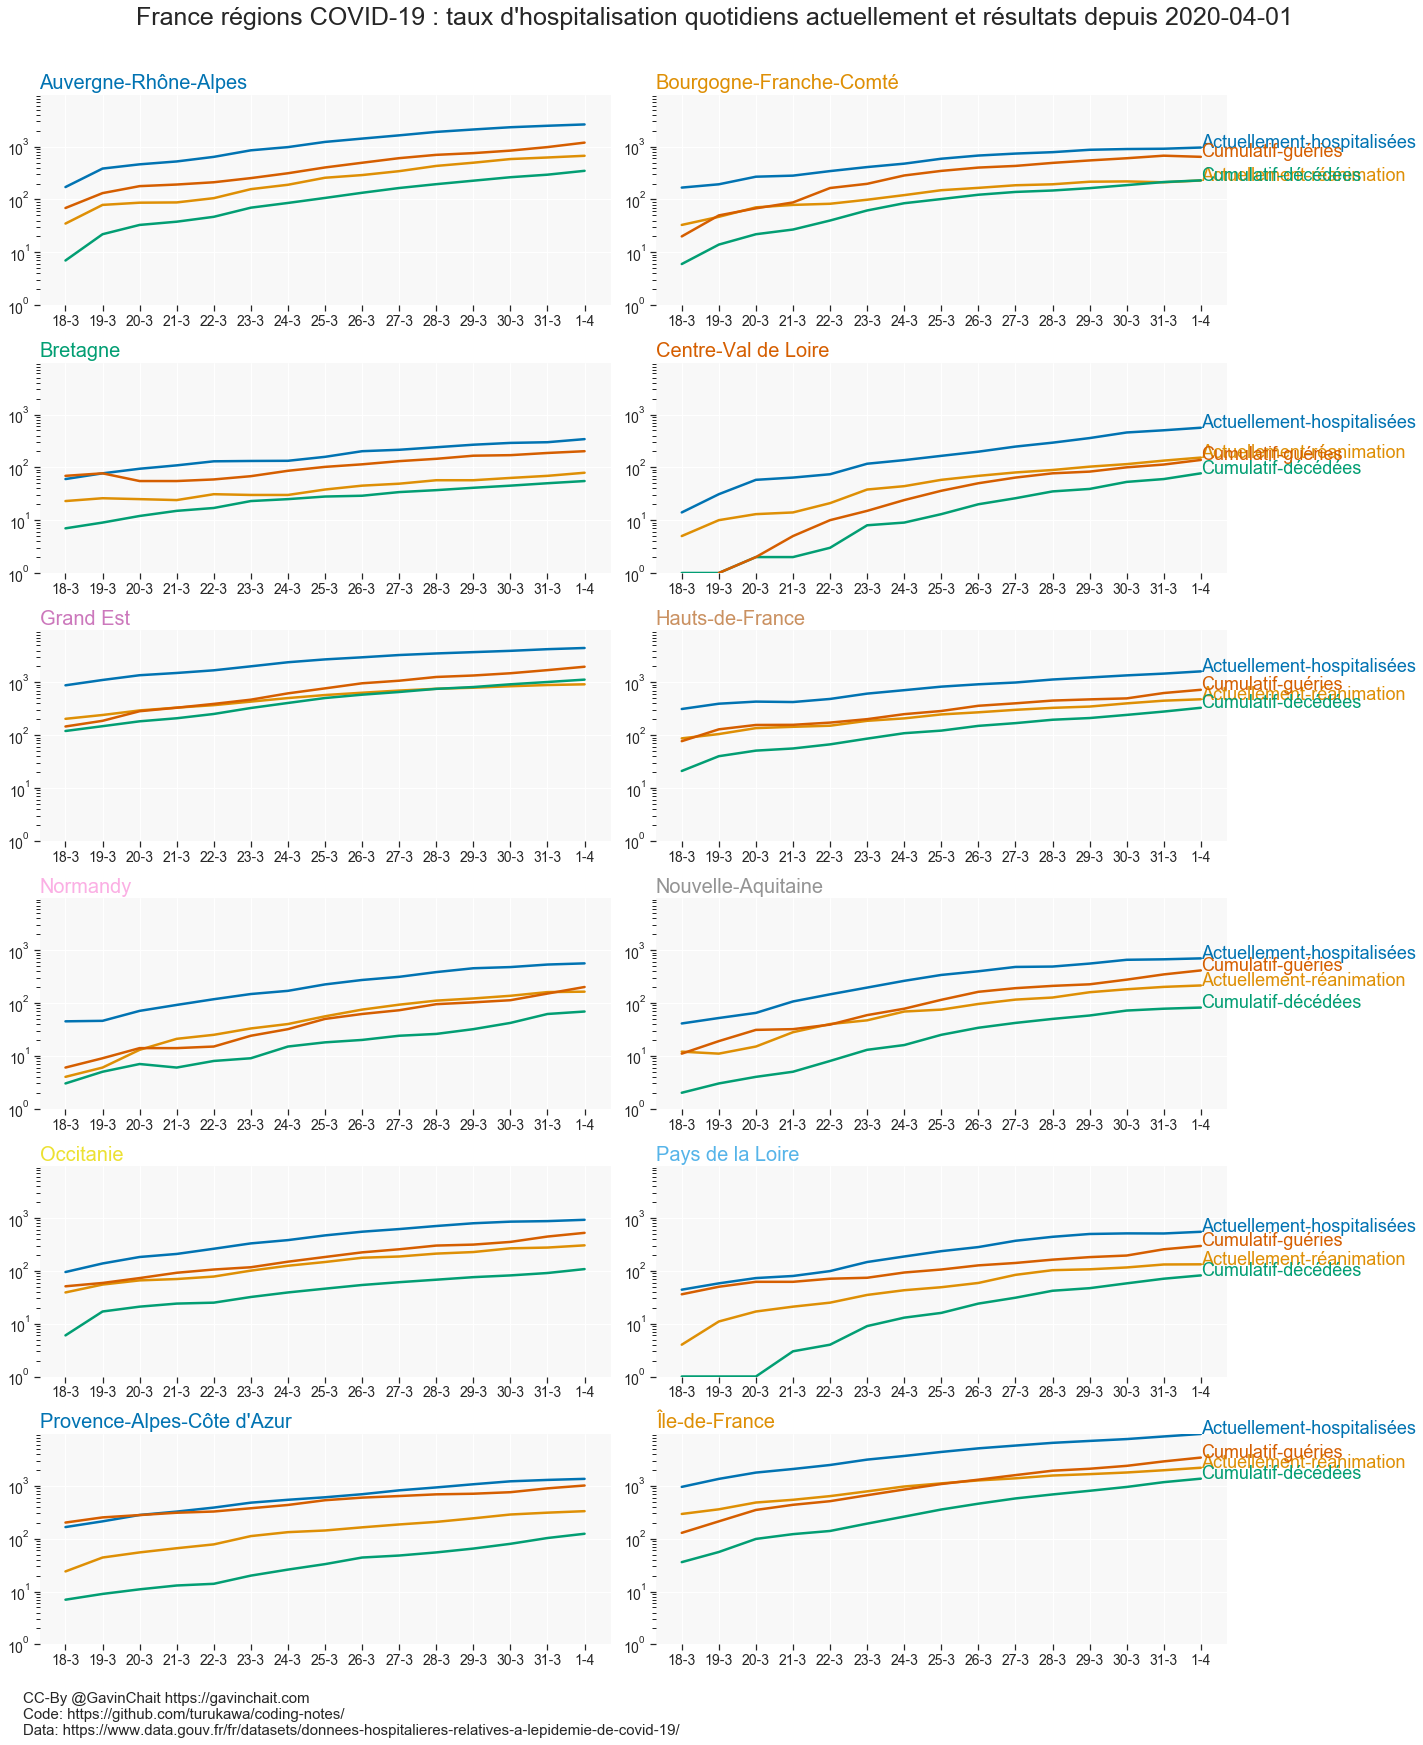

In [11]:
dfl = df.copy()
sub_regions = dfl[(dfl["Date"] == latest_date) & 
                  (dfl["Actuellement-hospitalisées"] >= 100)]["Région"].unique()
dfl = dfl[dfl["Région"].isin(sub_regions)]
plot_columns = ["Cumulatif-décédées", "Cumulatif-guéries", 
                "Actuellement-hospitalisées", "Actuellement-réanimation"]
data_min = dfl[plot_columns].min().min()+1
data_max = dfl[plot_columns].max().max()+1
region_count = sub_regions.size
rows = int(round(region_count/2)) + region_count % 2
fig, ax = plt.subplots(figsize=(20, 25))
fig.patch.set_facecolor('white')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(True, 'major', 'y', ls='--', lw=.5, c='k', alpha=.3)
plt.tick_params(axis='both', which='both', bottom='off', top='off',
                labelbottom='on', left='off', right='off', labelleft='on')
pN = 0
for region, data in dfl[["Région", "Date"] + plot_columns].groupby("Région"):
    drawing = pd.pivot_table(data[["Région", "Date"] + plot_columns], 
                         values=plot_columns,
                         index=["Région"],
                         columns=["Date"]).sum()
    pN+=1
    sub_ax = plt.subplot(rows, 2, pN)
    sub_ax.spines['top'].set_visible(False)
    sub_ax.spines['bottom'].set_visible(False)
    sub_ax.spines['right'].set_visible(False)
    sub_ax.spines['left'].set_visible(False)
    sub_ax.get_xaxis().tick_bottom()
    sub_ax.get_yaxis().tick_left()
    fig.subplots_adjust(left=.06, right=.75, bottom=.02, top=.94)
    for n, (column, sub_data) in enumerate(drawing.groupby(level=0)):
        plot_dates = [F"{dt.date().day}-{dt.date().month}" for dt in sub_data.index.get_level_values("Date")]
        y_pos = sub_data[-1] - 0.05
        line = plt.plot(plot_dates,
                        list(sub_data),
                        lw=2.5,
                        color=color_sequence[n])
        if pN % 2 == 0:
            plt.text(plot_dates[-1], y_pos, column, fontsize=18, color=color_sequence[n])
    sub_ax.set_yscale("log")
    sub_ax.set_ylim(data_min, data_max)
    plt.yticks(fontsize=14, fontweight=0)
    plt.xticks(fontsize=14, fontweight=0)
    plt.title(F"{region}", loc='left', fontsize=20, fontweight=2, color=color_sequence[pN-1])
title = F"France régions COVID-19 : taux d'hospitalisation quotidiens actuellement et résultats depuis {latest_date.date().isoformat()}"
fig.suptitle(title, fontsize=25, ha='center')
text = F"""
CC-By @GavinChait https://gavinchait.com
Code: https://github.com/turukawa/coding-notes/
Data: {current_source}"""
plt.gcf().text(0.02, 0.02, text, fontsize=15)
fig.tight_layout(rect=(0,0.05,1,0.95))

In [ ]:
text = F"""
France COVID-19 : cumulative update of infection status since {latest_date.date().isoformat()}.
France COVID-19 : mise à jour cumulative du statut de l'infection depuis {latest_date.date().isoformat()}. 
#opendata
"""
print(text)

In [ ]:
dfl = df.copy()
plot_columns = ["Cumulatif-décédées", "Cumulatif-guéries", 
                "Cumulatif-hospitalisées", "Cumulatif-réanimation"]
# https://stackoverflow.com/a/29370182
data_min = 0
data_max = int(round(df[plot_columns].max().max(),-1))
drawing = pd.pivot_table(dfl[["Région", "Date"] + plot_columns], 
                         values=plot_columns,
                         index=["Région"],
                         columns=["Date"]).sum()
color_sequence = sns.color_palette("colorblind", 15)
sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})
fig, ax = plt.subplots(1, 1, figsize=(20, 15))
fig.patch.set_facecolor('white')
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()

fig.subplots_adjust(left=.06, right=.75, bottom=.02, top=.94)
ax.set_xlim(drawing.index.get_level_values("Date").min().date(),
            drawing.index.get_level_values("Date").max().date())
#ax.set_ylim(data_min, data_max)
ax.set_yscale("log")

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(True, 'major', 'y', ls='--', lw=.5, c='k', alpha=.3)
plt.tick_params(axis='both', which='both', bottom='off', top='off',
                labelbottom='on', left='off', right='off', labelleft='on')
for n, (column, data) in enumerate(drawing.groupby(level=0)):
    plot_dates = [dt.date() for dt in data.index.get_level_values("Date")]
    y_pos = data[-1] - 0.05
    line = plt.plot(plot_dates,
                    list(data),
                    lw=2.5,
                    color=color_sequence[n])
    plt.text(max(plot_dates), y_pos, column, fontsize=18, color=color_sequence[n])
title = F"France COVID-19 : mise à jour cumulative du statut de l'infection depuis {latest_date.date().isoformat()}"
fig.suptitle(title, fontsize=25, ha='center')
text = """
CC-By @GavinChait https://gavinchait.com
Code: https://github.com/turukawa/coding-notes/
Data: https://github.com/opencovid19-fr/data"""
plt.gcf().text(0.02, 0.02, text, fontsize=16)
fig.tight_layout(rect=(0,0.065,1,1))
plt.show()

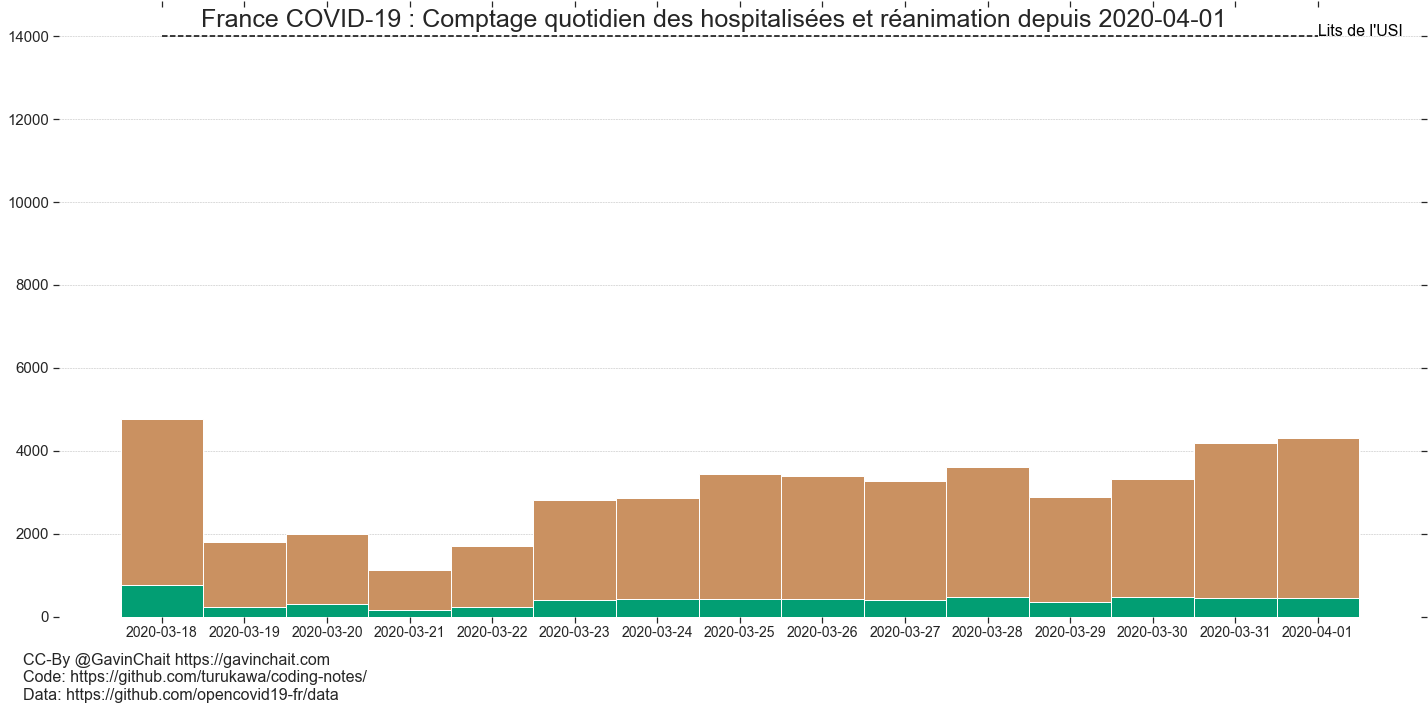

In [15]:
dfl = df.copy()
plot_columns = ["Réanimation", "Hospitalisées"]
# https://stackoverflow.com/a/29370182
# https://stackoverflow.com/a/29370182
data_min = 0
data_max = int(round(dfl[plot_columns].max().max(),-1))
drawing = pd.pivot_table(dfl[["Région", "Date"] + plot_columns], 
                         values=plot_columns,
                         index=["Région"],
                         columns=["Date"]).sum()
color_sequence = sns.color_palette("colorblind", 15)
sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
fig.patch.set_facecolor('white')
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, 'major', 'y', ls='--', lw=.5, c='k', alpha=.3)
plt.tick_params(axis='both', which='both', bottom='off', top='off',
                labelbottom='on', left='off', right='off', labelleft='on')

barWidth = 1
draw_order = {column: data for column, data in drawing.groupby(level=0)}
for n, column in enumerate(plot_columns):
    data = draw_order[column]
    plot_dates = [dt.date() for dt in data.index.get_level_values("Date")]
    if n > 0:
        plt.bar(plot_dates, list(data), bottom=bottom, color=color_sequence[5], 
                edgecolor='white', width=barWidth)
    else:
        plt.bar(plot_dates, list(data), color=color_sequence[2], 
                edgecolor='white', width=barWidth)
    bottom = list(data)
    
# Custom X axis
plt.xticks(plot_dates, plot_dates, fontsize=14, fontweight=0)
plt.yticks(fontsize=15, fontweight=0)

line = plt.plot(plot_dates,
                [ICU_beds] * len(plot_dates),
                lw=1.5,
                ls='--',
                color="black")
plt.text(max(plot_dates), ICU_beds, "Lits de l'USI", fontsize=16, color="black")
 
title = F"France COVID-19 : Comptage quotidien des hospitalisées et réanimation depuis {latest_date.date().isoformat()}"
fig.suptitle(title, fontsize=25, ha='center')
text = """
CC-By @GavinChait https://gavinchait.com
Code: https://github.com/turukawa/coding-notes/
Data: https://github.com/opencovid19-fr/data"""
plt.gcf().text(0.02, 0.02, text, fontsize=16)
fig.tight_layout(rect=(0,0.085,1,1))
plt.show()

In [19]:
for n, column in enumerate(plot_columns):
    data = draw_order[column]
    plot_dates = [dt.date() for dt in data.index.get_level_values("Date")]
    bottom = list(data)
plot_columns

['Réanimation', 'Hospitalisées']

# Régional France COVID-19 : taux d'hospitalisation journaliers à cumulés

If the data were cleaner and for a longer time-span, this would look better than it does ... going to have to wait and see ...

In [ ]:
text = F"""
Regional France COVID-19 : daily to cumulative hospitalisation rates since {latest_date.date().isoformat()}.
Régional France COVID-19 : taux d'hospitalisation journaliers à cumulés depuis {latest_date.date().isoformat()}. 
#opendata
"""
print(text)

In [ ]:
dfl = df.copy()
plot_columns = ["Cumulatif-décédées", "Cumulatif-guéries", 
                "Cumulatif-hospitalisées", "Cumulatif-réanimation"]
plot_columns = ["Cumulatif-décédées", "Décédées"]

regions = []
deaths = []
cumulative_deaths = []

for region, data in dfl[["Région", "Date"] + plot_columns].groupby("Région"):
    for dt, sub_data in data[["Date"] + plot_columns].groupby("Date"):
        regions.append(region)
        deaths.append(sub_data.iloc[0]["Décédées"])
        cumulative_deaths.append(sub_data.iloc[0]["Cumulatif-décédées"])

# Prepare plot
df_plot = pd.DataFrame({"Région": regions, 
                        "Décédées": deaths , 
                        "Cumulatif-décédées": cumulative_deaths
                       })

for column in plot_columns:
    df_plot[column] = df_plot.groupby("Région")[column].rolling(2, min_periods=1).mean().reset_index(0,drop=True)
    #df['moving'] = df.groupby('object')['value'].transform(lambda x: x.rolling(10, 1).mean())
df_plot.head()

In [ ]:
dfl = df.copy()
plot_columns = ["Cumulatif-décédées", "Cumulatif-guéries", 
                "Cumulatif-hospitalisées", "Cumulatif-réanimation"]
plot_columns = ["Cumulatif-décédées", "Décédées"]

regions = []
deaths = []
cumulative_deaths = []

for region, data in dfl[["Région", "Date"] + plot_columns].groupby("Région"):
    for dt, sub_data in data[["Date"] + plot_columns].groupby("Date"):
        regions.append(region)
        deaths.append(sub_data.iloc[0]["Décédées"])
        cumulative_deaths.append(sub_data.iloc[0]["Cumulatif-décédées"])

# Prepare plot
df_plot = pd.DataFrame({"Région": regions, 
                        "Décédées": deaths , 
                        "Cumulatif-décédées": cumulative_deaths
                       })
for column in plot_columns:
    df_plot[column] = df_plot.groupby("Région")[column].rolling(5, min_periods=2).mean().reset_index(0,drop=True)

fig, ax = plt.subplots(1, 1, figsize=(20, 10))
fig.patch.set_facecolor('white')
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()

fig.subplots_adjust(left=.06, right=.75, bottom=.02, top=.94)
#ax.set_ylim(df_plot["Décédées"].min(),
#            df_plot["Décédées"].max())
#ax.set_xlim(df_plot["Cumulatif-décédées"].min(),
#            df_plot["Cumulatif-décédées"].max(),)
#ax.set_ylim(data_min, data_max)
ax.set_xscale("log")
ax.set_yscale("log")
for n, (region, data) in enumerate(df_plot.groupby("Région")):
    line = plt.plot(data["Cumulatif-décédées"],
                    data["Décédées"],
                    lw=2.5,
                    color=color_sequence[n])

## Carte des points

In [14]:
boundaries = pd.merge(shape_data, df[df["Date"] == latest_date], 
                      how="outer", 
                      left_on="region", 
                      right_on="Région", 
                      indicator=True)
boundaries = boundaries[boundaries["_merge"]=="both"]

centroidseries = shape_data['geometry'].centroid
centroids = shape_data.copy()
centroids["geometry"] = centroidseries

centroids = pd.merge(centroids, df[df["Date"] == latest_date], 
                     how="outer", 
                     left_on="region", 
                     right_on="Région", 
                     indicator=True)
centroids = centroids[centroids["_merge"]=="both"]

ax = gplt.webmap(boundaries, 
                 projection=gcrs.WebMercator(), 
                 figsize=(15,15))
gplt.pointplot(centroids,
               projection=gcrs.AlbersEqualArea(),
               scale="Cumulatif-hospitalisées", limits=(20, 100),
               hue="Cumulatif-hospitalisées", cmap="copper",
               ax=ax)

NameError: name 'shape_data' is not defined

## Graphiques linéaires

In [ ]:
# https://stackoverflow.com/a/29370182
start_date = datetime.strptime("2020-03-18", "%Y-%m-%d")
mask = (df["Date"] > start_date) & (df["Date"] <= latest_date)
data_min = int(round(df[df["Région"].isin(boundaries["Région"])]["Cumulatif-hospitalisées"].min(),-1))
data_max = int(round(df[df["Région"].isin(boundaries["Région"])]["Cumulatif-hospitalisées"].max(),-1))
drawing = pd.pivot_table(df[df["Région"].isin(boundaries["Région"])].loc[mask],
                         values="Cumulatif-hospitalisées",
                         index=["Date"],
                         columns=["Région"])
color_sequence = ['#1f77b4', '#aec7e8', '#ff7f0e', '#ffbb78', '#2ca02c',
                  '#98df8a', '#d62728', '#ff9896', '#9467bd', '#c5b0d5',
                  '#8c564b', '#c49c94', '#e377c2', '#f7b6d2', '#7f7f7f',
                  '#c7c7c7', '#bcbd22', '#dbdb8d', '#17becf', '#9edae5']
fig, ax = plt.subplots(1, 1, figsize=(20, 15))
fig.patch.set_facecolor('white')
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()

fig.subplots_adjust(left=.06, right=.75, bottom=.02, top=.94)
ax.set_xlim(drawing.index.min().date(), drawing.index.max().date())
#ax.set_ylim(data_min, data_max)
ax.set_yscale("log")

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(True, 'major', 'y', ls='--', lw=.5, c='k', alpha=.3)
plt.tick_params(axis='both', which='both', bottom='off', top='off',
                labelbottom='on', left='off', right='off', labelleft='on')
for n, column in enumerate(drawing.columns):
    line = plt.plot(drawing.index,
                    drawing[column],
                    lw=2.5,
                    color=color_sequence[n])
    y_pos = drawing[column][-1] - 0.05
    plt.text(drawing.index.max().date(), y_pos, column, fontsize=18, color=color_sequence[n])
title = F"Régional France COVID-19 cumulatif hospitalisées depuis {drawing.index.max().date().isoformat()}"
fig.suptitle(title, fontsize=18, ha='center')

## Région infection doublant le temps

Référence : [Lisa Charlotte Rost, DataWrapper](https://blog.datawrapper.de/weekly-chart-coronavirus-doublingtimes/)

In [ ]:
N = 4
headers = ["Région",
           F"t. dbler ({N}j)",
           F"{N}j av.",
           "chg.",
           F"n. cas ({N}j)",
           F"{N}j av.",
           "chg."
          ]
rows = []
for name, region in df[df["Région"].isin(boundaries["Région"])].groupby(["Région"]):
    date_latest = region["Date"].max()
    date_N = date_latest - timedelta(days=N)
    date_2N = date_N - timedelta(days=N)
    # Lates
    yN = region[region["Date"] == date_latest].iloc[0]["Cumulatif-hospitalisées"]
    zN = region[region["Date"] == date_N].iloc[0]["Cumulatif-hospitalisées"]
    # le doublement du temps au cours des cinq derniers jours
    double_N = doubling_time(x=N, y=yN, z=zN)
    # les nouveaux cas confirmés au cours des cinq derniers jours
    case_N = yN - zN
    # Précédent
    y2N = region[region["Date"] == date_N].iloc[0]["Cumulatif-hospitalisées"]
    z2N = region[region["Date"] == date_2N].iloc[0]["Cumulatif-hospitalisées"]
    # le doublement du temps au cours des cinq derniers jours
    double_2N = doubling_time(x=N, y=y2N, z=z2N)
    # les cas confirmés dans les cinq jours précédents
    case_2N = y2N - z2N
    # Changement dans le temps de doublement
    if double_N == double_2N: double_change = "~"
    if double_N > double_2N:
        if (double_N / double_2N) - 1 >= 0.5:
            double_change = "▲▲"
        else:
            double_change = "▲"
    if double_2N > double_N:
        if (double_2N / double_N) - 1 >= 0.5:
            double_change = "▼▼"
        else:
            double_change = "▼"
    # Changement dans les cas confirmés
    if case_N == case_2N: case_change = "~"
    if case_N > case_2N:
        if (case_N / case_2N) - 1 >= 0.5:
            case_change = "▲▲"
        else:
            case_change = "▲"
    if case_2N > case_N:
        if (case_2N / case_N) - 1 >= 0.5:
            case_change = "▼▼"
        else:
            case_change = "▼"
    rows.append([
        name,
        F"{double_N:.2f}", F"{double_2N:.2f}", double_change,
        F"{case_N:,}", F"{case_2N:,}", case_change
    ])
    
print(tabulate(rows,
               headers=headers, 
               tablefmt="fancy_grid"))

In [ ]:
N = 3
headers = ["Région",
           F"t. dbler ({N}j)",
           F"{N}j av.",
           "chg.",
           F"n. cas ({N}j)",
           F"{N}j av.",
           "chg."
          ]
rows = []
for name, region in df[df["Région"].isin(boundaries["Région"])].groupby(["Région"]):
    date_latest = region["Date"].max()
    date_N = date_latest - timedelta(days=N)
    date_2N = date_N - timedelta(days=N)
    # Lates
    yN = region[region["Date"] == date_latest].iloc[0]["Cumulatif-cas-confirmés"]
    zN = region[region["Date"] == date_N].iloc[0]["Cumulatif-cas-confirmés"]
    # le doublement du temps au cours des cinq derniers jours
    double_N = doubling_time(x=N, y=yN, z=zN)
    # les nouveaux cas confirmés au cours des cinq derniers jours
    case_N = yN - zN
    # Précédent
    y2N = region[region["Date"] == date_N].iloc[0]["Cumulatif-cas-confirmés"]
    z2N = region[region["Date"] == date_2N].iloc[0]["Cumulatif-cas-confirmés"]
    # le doublement du temps au cours des cinq derniers jours
    double_2N = doubling_time(x=N, y=y2N, z=z2N)
    # les cas confirmés dans les cinq jours précédents
    case_2N = y2N - z2N
    # Changement dans le temps de doublement
    if double_N == double_2N: double_change = "~"
    if double_N > double_2N:
        if (double_N / double_2N) - 1 >= 0.5:
            double_change = "▲▲"
        else:
            double_change = "▲"
    if double_2N > double_N:
        if (double_2N / double_N) - 1 >= 0.5:
            double_change = "▼▼"
        else:
            double_change = "▼"
    # Changement dans les cas confirmés
    if case_N == case_2N: case_change = "~"
    if case_N > case_2N:
        if (case_N / case_2N) - 1 >= 0.5:
            case_change = "▲▲"
        else:
            case_change = "▲"
    if case_2N > case_N:
        if (case_2N / case_N) - 1 >= 0.5:
            case_change = "▼▼"
        else:
            case_change = "▼"
    rows.append([
        name,
        F"{double_N:.2f}", F"{double_2N:.2f}", double_change,
        F"{case_N:,}", F"{case_2N:,}", case_change
    ])
    
print(tabulate(rows,
               headers=headers, 
               tablefmt="fancy_grid"))

In [13]:
# https://stackoverflow.com/a/54031113
import warnings
warnings.filterwarnings('ignore')
sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})

start_date = datetime.strptime("2020-03-10", "%Y-%m-%d")
mask = (df["Date"] > start_date) & (df["Date"] <= latest_date)

sm = sns.FacetGrid(df[df["Région"].isin(boundaries["Région"])].loc[mask],
                      col="Région", 
                      col_wrap=4, size=3, 
                      aspect=2, 
                      margin_titles=True)
sm = sm.map(plt.bar, "Date", "Hospitalisées")

sm.set_titles("{col_name}", size=22).set_ylabels(size=25).set_yticklabels(size=15)\
                                    .set_xlabels(size=20).set_xticklabels(size=10)
sm.fig.tight_layout(w_pad=2)

NameError: name 'boundaries' is not defined

## Cumulé de personnes décédées

In [ ]:
# Ouvrez le fichier "shapefile" appelé "contours-geographiques-des-nouvelles-regions-metropole.shp" 
# et notez que - si vous faites cela chez vous ordinateur, vous devrez charger le fichier à partir 
# de l'endroit où vous l'avez enregistré
boundaries = pd.merge(shape_data, df[df["Date"] == latest_date], 
                      how="outer", 
                      left_on="region", 
                      right_on="Région", 
                      indicator=True)
boundaries = boundaries[boundaries["_merge"]=="both"]

centroidseries = shape_data['geometry'].centroid
centroids = shape_data.copy()
centroids["geometry"] = centroidseries

centroids = pd.merge(centroids, df[df["Date"] == latest_date], 
                     how="outer", 
                     left_on="region", 
                     right_on="Région", 
                     indicator=True)
centroids = centroids[centroids["_merge"]=="both"]

ax = gplt.webmap(boundaries, 
                 projection=gcrs.WebMercator(), 
                 figsize=(15,15))
gplt.pointplot(centroids,
               projection=gcrs.AlbersEqualArea(),
               scale="Cumulatif-décédées", limits=(20, 100),
               hue="Cumulatif-décédées", cmap="copper",
               ax=ax)

In [ ]:
# https://matplotlib.org/examples/showcase/bachelors_degrees_by_gender.html
start_date = datetime.strptime("2020-03-18", "%Y-%m-%d")
mask = (df["Date"] > start_date) & (df["Date"] <= latest_date)
data_min = int(round(df[df["Région"].isin(boundaries["Région"])]["Cumulatif-décédées"].min(),-1))
data_max = int(round(df[df["Région"].isin(boundaries["Région"])]["Cumulatif-décédées"].max(),-1))
drawing = pd.pivot_table(df[df["Région"].isin(boundaries["Région"])].loc[mask],
                         values="Cumulatif-décédées",
                         index=["Date"],
                         columns=["Région"])
color_sequence = ['#1f77b4', '#aec7e8', '#ff7f0e', '#ffbb78', '#2ca02c',
                  '#98df8a', '#d62728', '#ff9896', '#9467bd', '#c5b0d5',
                  '#8c564b', '#c49c94', '#e377c2', '#f7b6d2', '#7f7f7f',
                  '#c7c7c7', '#bcbd22', '#dbdb8d', '#17becf', '#9edae5']
fig, ax = plt.subplots(1, 1, figsize=(20, 15))
fig.patch.set_facecolor('white')
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()

fig.subplots_adjust(left=.06, right=.75, bottom=.02, top=.94)
ax.set_xlim(drawing.index.min().date(), drawing.index.max().date())
#ax.set_ylim(data_min, data_max)
ax.set_yscale("log")

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(True, 'major', 'y', ls='--', lw=.5, c='k', alpha=.3)
plt.tick_params(axis='both', which='both', bottom='off', top='off',
                labelbottom='on', left='off', right='off', labelleft='on')
for n, column in enumerate(drawing.columns):
    line = plt.plot(drawing.index,
                    drawing[column],
                    lw=2.5,
                    color=color_sequence[n])
    y_pos = drawing[column][-1] - 0.05
    plt.text(drawing.index.max().date(), y_pos, column, fontsize=18, color=color_sequence[n])
title = F"Régional France COVID-19 nombre cumulé de personnes décédées depuis {drawing.index.max().date().isoformat()}"
fig.suptitle(title, fontsize=18, ha='center')

In [ ]:
N = 4
headers = ["Région",
           F"t. dbler ({N}j)",
           F"{N}j av.",
           "chg.",
           F"n. cas ({N}j)",
           F"{N}j av.",
           "chg."
          ]
rows = []
for name, region in df[df["Région"].isin(boundaries["Région"])].groupby(["Région"]):
    date_latest = region["Date"].max()
    date_N = date_latest - timedelta(days=N)
    date_2N = date_N - timedelta(days=N)
    # Lates
    yN = region[region["Date"] == date_latest].iloc[0]["Cumulatif-décédées"]
    zN = region[region["Date"] == date_N].iloc[0]["Cumulatif-décédées"]
    # le doublement du temps au cours des cinq derniers jours
    double_N = doubling_time(x=N, y=yN, z=zN)
    # les nouveaux cas confirmés au cours des cinq derniers jours
    case_N = yN - zN
    # Précédent
    y2N = region[region["Date"] == date_N].iloc[0]["Cumulatif-décédées"]
    z2N = region[region["Date"] == date_2N].iloc[0]["Cumulatif-décédées"]
    # le doublement du temps au cours des cinq derniers jours
    double_2N = doubling_time(x=N, y=y2N, z=z2N)
    # les cas confirmés dans les cinq jours précédents
    case_2N = y2N - z2N
    # Changement dans le temps de doublement
    if double_N == double_2N: double_change = "~"
    if double_N > double_2N:
        if (double_N / double_2N) - 1 >= 0.5:
            double_change = "▲▲"
        else:
            double_change = "▲"
    if double_2N > double_N:
        if (double_2N / double_N) - 1 >= 0.5:
            double_change = "▼▼"
        else:
            double_change = "▼"
    # Changement dans les cas confirmés
    if case_N == case_2N: case_change = "~"
    if case_N > case_2N:
        if (case_N / case_2N) - 1 >= 0.5:
            case_change = "▲▲"
        else:
            case_change = "▲"
    if case_2N > case_N:
        if (case_2N / case_N) - 1 >= 0.5:
            case_change = "▼▼"
        else:
            case_change = "▼"
    rows.append([
        name,
        F"{double_N:.2f}", F"{double_2N:.2f}", double_change,
        F"{case_N:,}", F"{case_2N:,}", case_change
    ])
print(tabulate(rows,
               headers=headers, 
               tablefmt="fancy_grid"))

In [ ]:
# https://stackoverflow.com/a/54031113
import warnings
warnings.filterwarnings('ignore')

sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})
start_date = datetime.strptime("2020-03-18", "%Y-%m-%d")
mask = (df["Date"] > start_date) & (df["Date"] <= latest_date)
    
sm = sns.FacetGrid(df[df["Région"].isin(boundaries["Région"])].loc[mask],
                      col="Région", 
                      col_wrap=4, size=3, 
                      aspect=2, 
                      margin_titles=True)
sm = sm.map(plt.bar, "Date", "Décédées")

sm.set_titles("{col_name}", size=22).set_ylabels(size=25).set_yticklabels(size=15)\
                                    .set_xlabels(size=20).set_xticklabels(size=10)
sm.fig.tight_layout(w_pad=2)

In [ ]:
# Ouvrez le fichier "shapefile" appelé "contours-geographiques-des-nouvelles-regions-metropole.shp" 
# et notez que - si vous faites cela chez vous ordinateur, vous devrez charger le fichier à partir 
# de l'endroit où vous l'avez enregistré
boundaries = pd.merge(shape_data, df[df["Date"] == latest_date], 
                      how="outer", 
                      left_on="region", 
                      right_on="Région", 
                      indicator=True)
boundaries = boundaries[boundaries["_merge"]=="both"]

centroidseries = shape_data['geometry'].centroid
centroids = shape_data.copy()
centroids["geometry"] = centroidseries

centroids = pd.merge(centroids, df[df["Date"] == latest_date], 
                     how="outer", 
                     left_on="region", 
                     right_on="Région", 
                     indicator=True)
centroids = centroids[centroids["_merge"]=="both"]

ax = gplt.webmap(boundaries, 
                 projection=gcrs.WebMercator(), 
                 figsize=(15,15))
gplt.pointplot(centroids,
               projection=gcrs.AlbersEqualArea(),
               scale="Cumulatif-guéries", limits=(20, 100),
               hue="Cumulatif-guéries", cmap="copper",
               ax=ax)

In [ ]:
# https://matplotlib.org/examples/showcase/bachelors_degrees_by_gender.html
start_date = datetime.strptime("2020-03-18", "%Y-%m-%d")
mask = (df["Date"] > start_date) & (df["Date"] <= latest_date)
data_min = int(round(df[df["Région"].isin(boundaries["Région"])]["Cumulatif-guéries"].min(),-1))
data_max = int(round(df[df["Région"].isin(boundaries["Région"])]["Cumulatif-guéries"].max(),-1))
drawing = pd.pivot_table(df[df["Région"].isin(boundaries["Région"])].loc[mask],
                         values="Cumulatif-guéries",
                         index=["Date"],
                         columns=["Région"])
color_sequence = ['#1f77b4', '#aec7e8', '#ff7f0e', '#ffbb78', '#2ca02c',
                  '#98df8a', '#d62728', '#ff9896', '#9467bd', '#c5b0d5',
                  '#8c564b', '#c49c94', '#e377c2', '#f7b6d2', '#7f7f7f',
                  '#c7c7c7', '#bcbd22', '#dbdb8d', '#17becf', '#9edae5']
fig, ax = plt.subplots(1, 1, figsize=(20, 15))
fig.patch.set_facecolor('white')
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()

fig.subplots_adjust(left=.06, right=.75, bottom=.02, top=.94)
ax.set_xlim(drawing.index.min().date(), drawing.index.max().date())
#ax.set_ylim(data_min, data_max)
ax.set_yscale("log")

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(True, 'major', 'y', ls='--', lw=.5, c='k', alpha=.3)
plt.tick_params(axis='both', which='both', bottom='off', top='off',
                labelbottom='on', left='off', right='off', labelleft='on')
for n, column in enumerate(drawing.columns):
    line = plt.plot(drawing.index,
                    drawing[column],
                    lw=2.5,
                    color=color_sequence[n])
    y_pos = drawing[column][-1] - 0.05
    plt.text(drawing.index.max().date(), y_pos, column, fontsize=18, color=color_sequence[n])
title = F"Régional France COVID-19 nombre cumulé de personnes guéries depuis {drawing.index.max().date().isoformat()}"
fig.suptitle(title, fontsize=18, ha='center')

In [ ]:
N = 4
headers = ["Région",
           F"t. dbler ({N}j)",
           F"{N}j av.",
           "chg.",
           F"n. cas ({N}j)",
           F"{N}j av.",
           "chg."
          ]
rows = []
for name, region in df[df["Région"].isin(boundaries["Région"])].groupby(["Région"]):
    date_latest = region["Date"].max()
    date_N = date_latest - timedelta(days=N)
    date_2N = date_N - timedelta(days=N)
    # Lates
    yN = region[region["Date"] == date_latest].iloc[0]["Cumulatif-guéries"]
    zN = region[region["Date"] == date_N].iloc[0]["Cumulatif-guéries"]
    # le doublement du temps au cours des cinq derniers jours
    double_N = doubling_time(x=N, y=yN, z=zN)
    # les nouveaux cas confirmés au cours des cinq derniers jours
    case_N = yN - zN
    # Précédent
    y2N = region[region["Date"] == date_N].iloc[0]["Cumulatif-guéries"]
    z2N = region[region["Date"] == date_2N].iloc[0]["Cumulatif-guéries"]
    # le doublement du temps au cours des cinq derniers jours
    double_2N = doubling_time(x=N, y=y2N, z=z2N)
    # les cas confirmés dans les cinq jours précédents
    case_2N = y2N - z2N
    # Changement dans le temps de doublement
    if double_N == double_2N: double_change = "~"
    if double_N > double_2N:
        if (double_N / double_2N) - 1 >= 0.5:
            double_change = "▲▲"
        else:
            double_change = "▲"
    if double_2N > double_N:
        if (double_2N / double_N) - 1 >= 0.5:
            double_change = "▼▼"
        else:
            double_change = "▼"
    # Changement dans les cas confirmés
    if case_N == case_2N: case_change = "~"
    if case_N > case_2N:
        if (case_N / case_2N) - 1 >= 0.5:
            case_change = "▲▲"
        else:
            case_change = "▲"
    if case_2N > case_N:
        if (case_2N / case_N) - 1 >= 0.5:
            case_change = "▼▼"
        else:
            case_change = "▼"
    rows.append([
        name,
        F"{double_N:.2f}", F"{double_2N:.2f}", double_change,
        F"{case_N:,}", F"{case_2N:,}", case_change
    ])
print(tabulate(rows,
               headers=headers, 
               tablefmt="fancy_grid"))

In [ ]:
# https://stackoverflow.com/a/54031113
import warnings
warnings.filterwarnings('ignore')

sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})
start_date = datetime.strptime("2020-03-18", "%Y-%m-%d")
mask = (df["Date"] > start_date) & (df["Date"] <= latest_date)
    
sm = sns.FacetGrid(df[df["Région"].isin(boundaries["Région"])].loc[mask],
                      col="Région", 
                      col_wrap=4, size=3, 
                      aspect=2, 
                      margin_titles=True)
sm = sm.map(plt.bar, "Date", "Guéries")

sm.set_titles("{col_name}", size=22).set_ylabels(size=25).set_yticklabels(size=15)\
                                    .set_xlabels(size=20).set_xticklabels(size=10)
sm.fig.tight_layout(w_pad=2)

In [ ]:
#https://python-graph-gallery.com/184-lollipop-plot-with-2-groups/

## Choroplèthe & expériences 

In [ ]:
fig, ax = plt.subplots(figsize=(15,15))
boundaries.plot(ax=ax, column="Cas-confirmés", cmap="OrRd")

In [ ]:
# https://stackoverflow.com/a/54031113
import warnings
warnings.filterwarnings('ignore')

def facetgrid_two_axes(*args, **kwargs):
    data = kwargs.pop("data")
    dual_axis = kwargs.pop("dual_axis")
    alpha = kwargs.pop("alpha", 0.2)
    kwargs.pop("color")
    ax = plt.gca()
    if dual_axis:
        ax2 = ax.twinx()
        ax2.set_ylabel("Cumulatif-cas-confirmés")
    # https://github.com/matplotlib/matplotlib/issues/13142/#issuecomment-453174700
    ax.bar(data["Date"], data["Cas-confirmés"], **kwargs, color='red',alpha=alpha,
           width=np.timedelta64(12, 'h'))
    if dual_axis:
        ax2.plot(data["Date"], data["Cumulatif-cas-confirmés"], **kwargs, color='blue',alpha=alpha)
        
sm = sns.FacetGrid(df[df["Région"].isin(boundaries["Région"])],
                      col="Région", 
                      col_wrap=4, size=3, 
                      aspect=2, 
                      margin_titles=True)
#sm = sm.map(plt.bar, "Date", "Cas-confirmés")
#sm = sm.map(plt.plot, "Date", "Cumulatif-cas-confirmés").set(yscale ='log')
sm = sm.map_dataframe(facetgrid_two_axes, dual_axis=True)\
       .set_axis_labels("Date", "Cas-confirmés")

sm.set_titles("{col_name}", size=22).set_ylabels(size=25).set_yticklabels(size=15)\
                                    .set_xlabels(size=20).set_xticklabels(size=10)
sm.fig.tight_layout(w_pad=2)

In [ ]:
import warnings
warnings.filterwarnings('ignore')

population_file = "data/France-population.csv"
pf = pd.read_csv(population_file)
chunks = []
for name, region in df[df["Région"].isin(boundaries["Région"])].groupby(["Région"]):
    d = pf[pf["Région"]==name]["Population"].values[0] / 1000
    region.loc[:, "Cumulatif-cas-confirmés"] = region.apply(lambda x: x["Cumulatif-cas-confirmés"]/d, 
                                                            axis=1)
    chunks.append(region)
pf = pd.concat(chunks)
drawing = pd.pivot_table(pf,
                         values="Cumulatif-cas-confirmés",
                         index=["Date"],
                         columns=["Région"])
fig, ax = plt.subplots(figsize=(20,15))
fig.subplots_adjust(bottom=0.15, left=0.2)
ax.set_ylabel("Cumulatif Cas-confirmés / mille", size=25)
ax.set_xlabel("Date", size=20)
drawing.plot(grid=True, logy=True, fontsize=14, ax=ax)
h, l = ax.get_legend_handles_labels()
ax.legend(h, l, fontsize=14, title_fontsize="large")

In [ ]:
# https://seaborn.pydata.org/examples/kde_ridgeplot.html
sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

dfs = df[df["Région"].isin(boundaries["Région"])].copy()

pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
g = sns.FacetGrid(dfs, row="Région", hue="Région", aspect=8, palette=pal)

# Draw the densities in a few steps
g.map(sns.kdeplot, "Cas-confirmés", clip_on=False, shade=True, alpha=1, lw=1.5, bw=.2)
g.map(sns.kdeplot, "Cas-confirmés", clip_on=False, color="w", lw=2, bw=.2)
g.map(plt.axhline, y=0, lw=2, clip_on=False)


# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color, size=25,
            ha="left", va="center", transform=ax.transAxes)

g.map(label, "Cas-confirmés")

# Set the subplots to overlap
g.fig.subplots_adjust(hspace=-.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[]).set_xlabels(size=20).set_xticklabels(size=15)
g.despine(bottom=True, left=True)

In [ ]:
####
# Hospital emergency and physician SOS data related to the COVID epidemic-19
# Données des urgences hospitalières et de SOS médecins relatives à l'épidémie de COVID-19
####

# Download latest data || Télécharger les dernières données 

url = "https://www.data.gouv.fr/en/datasets/r/d2af5160-a21d-47b7-8f30-3c20dade63b1"
data_file = "data/sursaud-covid19-region.csv"
urllib.request.urlretrieve(url, data_file)

## Population and Region codes

population_file = "data/France-population.csv"
pf = pd.read_csv(population_file)
pf = pf[pf["INSEE"].notnull()].astype({"INSEE": "int32"})
regions = dict(zip(pf["INSEE"], pf["Région"]))

## Read latest data and select data required

df = pd.read_csv(data_file)
df = df[df["sursaud_cl_age_corona"]=="0"]
df["reg"] = df["reg"].replace(regions)
latest_date = df["date_de_passage"].max()

## Prepare data

df = df.rename(columns={
    "reg": "Région", 
    "date_de_passage": "Date",
    "cas_confirmes": "Cumulatif-cas-confirmés",
    "hospitalises": "Hospitalisées",
    "reanimation": "Réanimation",
    "deces": "Cumulatif-décédées",
    "gueris": "Cumulatif-guéries",
    "depistes": "Cumulatif-dépistées",
    "date": "Date"  
})

latest_date = df["date_de_passage"].max()

# Filtrer par date limite
latest_date = df["Date"].max()

new_types = {c: "int32" for c in ["Cumulatif-cas-confirmés","Hospitalisées",
                                  "Réanimation","Cumulatif-décédées",
                                  "Cumulatif-guéries","Cumulatif-dépistées"]}
df = df.astype(new_types)
for column in ["Hospitalisées", "Réanimation"]:
    df[F"Cumulatif-{column.lower()}"] = df.groupby("Région")[column].cumsum()
new_columns = {
    "Cumulatif-cas-confirmés": "Cas-confirmés",
    "Cumulatif-décédées": "Décédées",
    "Cumulatif-guéries": "Guéries",
    "Cumulatif-dépistées": "Dépistées"
}
for c, nc in new_columns.items():
    # https://stackoverflow.com/a/48348006
    df[nc] = df.groupby(["Région"])[c].diff().fillna(df[c])
df["Date"] = pd.to_datetime(df.Date)
# Ouvrez le fichier "shapefile" appelé "contours-geographiques-des-nouvelles-regions-metropole.shp" 
# et notez que - si vous faites cela chez vous ordinateur, vous devrez charger le fichier à partir 
# de l'endroit où vous l'avez enregistré
shape_data = gpd.GeoDataFrame.from_file("data/contours-geographiques-des-nouvelles-regions-metropole.shp")
regions = {"Grand-Est": "Grand Est",
           "Bourgogne-Franche-ComtÃ©": "Bourgogne-Franche-Comté", 
           "Auvergne-RhÃ´ne-Alpes": "Auvergne-Rhône-Alpes", 
           "Provence-Alpes-CÃ´te d'Azur": "Provence-Alpes-Côte d'Azur", 
           "Nouvelle Aquitaine": "Nouvelle-Aquitaine",
           "Ile-de-France": "Île-de-France"
          }
shape_data["region"] = shape_data["region"].replace(regions)

#for c in ["sursaud_cl_age_corona", "maille_code", "source_nom", "source_url", "source_archive", "source_type"]:
#    del df[c]

df[df["Date"] == latest_date]